In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob 

from astropy.table import Table

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# data from: https://www.ngdc.noaa.gov/stp/solar/solarflares.html
# but cleaned up a bit
FI_files = glob('FI_total/*.txt')

Requested Citation:

*The "Flare Index" dataset was prepared by the Kandilli Observatory and Earthquake Research Institute at the Bogazici University and made available through the NOAA National Geophysical Data Center (NGDC).*

In [4]:
years = pd.Series(FI_files).str[-8:-4].astype('float').values
years

array([ 1983.,  1997.,  2011.,  1996.,  1982.,  1994.,  1980.,  2013.,
        2012.,  1981.,  1995.,  1991.,  1985.,  1984.,  1990.,  1979.,
        1986.,  1992.,  2014.,  1993.,  1987.,  1978.,  2009.,  2008.,
        2006.,  2007.,  2005.,  2010.,  2004.,  2000.,  2001.,  2003.,
        2002.,  1976.,  1989.,  1988.,  1977.,  1998.,  1999.])

In [35]:
k=0

cnames=('Day', 'Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
df = pd.read_table(FI_files[k], skip_blank_lines=True, skiprows=7, delim_whitespace=True, 
                   skipfooter=4, names=cnames, engine='python')

FI = df.iloc[:,1:].sum(axis=0).values
DD = years[k]+np.arange(0,1,1/12)

In [36]:
for k in range(1,len(FI_files)):
    df = pd.read_table(FI_files[k], skip_blank_lines=True, skiprows=7, delim_whitespace=True, 
                   skipfooter=4, names=cnames, engine='python')

    FI = np.append(FI, df.iloc[:,1:].sum(axis=0).values)
    DD = np.append(DD, years[k]+np.arange(0,1,1/12))
#     print(years[k],np.shape(df.iloc[:,1:].sum(axis=0).values), np.shape(years[k]+np.arange(0,1,1/12)))

ss = np.argsort(DD)
DD = np.array(DD[ss], dtype='float')
FI = np.array(FI[ss], dtype='float')

In [37]:
FI0 = FI
DD0 = DD

DD = DD[0:380]
FI = FI[0:380]

Text(0, 0.5, 'Flare Index')

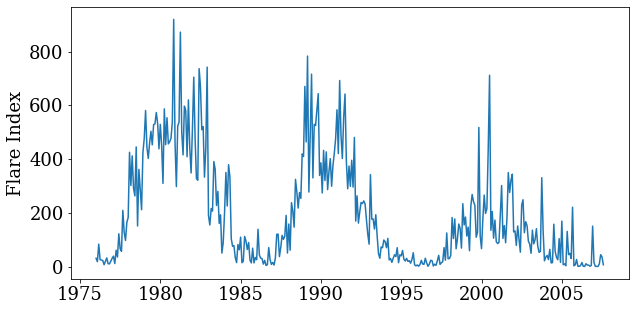

In [38]:
plt.figure(figsize=(10,5))
plt.plot(DD, FI)
plt.ylabel('Flare Index')

In [39]:
import celerite
from celerite import terms
from scipy.optimize import minimize
# A non-periodic component
# Q = 1.0 / np.sqrt(2.0)
# w0 = 44
# S0 = np.var(FI) / (w0 * Q)
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                        bounds=bounds)
# kernel.freeze_parameter('log_Q')

# A periodic component

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp,):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [43]:
bounds = dict(log_S0=(-0, 15), log_Q=(-15, 15), log_omega0=(-15, 5))

Q = 1.0 
w0 = 2*np.pi/11.
S0 = np.var(FI) / (w0 * Q)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(FI), fit_mean=True)
gp.compute(DD, yerr=(np.sqrt(FI + 0.75) + 1.0)+90.) # add extra Yerror term to account for scatter

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method='L-BFGS-B', bounds=bounds, args=(FI, gp))
gp.set_parameter_vector(soln.x)

x = np.linspace(1975, 2029, 500)
mu, var = gp.predict(FI, x, return_var=True)

print(2*np.pi / np.exp(gp.get_parameter_dict()['kernel:log_omega0']))

10.670498514


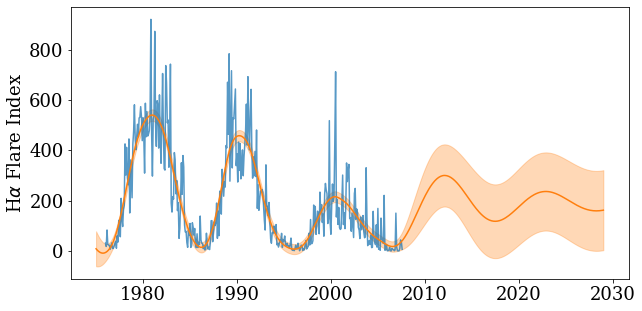

In [44]:
plt.figure(figsize=(10,5))
plt.plot(DD, FI, alpha=0.75)
# plt.plot(DD0, FI0, alpha=0.25)
plt.plot(x, mu)
plt.fill_between(x, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
                 edgecolor="none")

plt.ylabel(r'H$\alpha$ Flare Index')
plt.savefig('solar_flare_index_gp.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)